### Imports & Data download

In [ ]:
# !wget https://www.dropbox.com/s/7nmn6eu6x65e4rx/hackathon.zip
# !unzip hackathon.zip

In [ ]:
# !wget https://www.dropbox.com/s/8v1v93br11gc2y1/hackathon_test.zip
# !unzip hackathon_test.zip

In [ ]:
### Данные по зарплате городов и областей
# Источник:
# https://visasam.ru/russia/rabotavrf/zarplaty-v-rossii.html
# https://ria.ru/20211004/zarplata-1752715397.html

# !wget https://www.dropbox.com/s/fdav34n8a9wv9am/cities.zip
# !unzip cities.zip

In [ ]:
# !pip install catboost
# !pip install shap
# !pip install scikit-plot
# !pip install optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import joblib
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import shap
warnings.filterwarnings("ignore")

from catboost import CatBoostClassifier, Pool
%matplotlib inline

### Functions

In [ ]:
# Подготовка данных для моделей
def preprocess(df_init):
  df = df_init.copy()
  df['bundle_point'] = df['bundle'].apply(lambda x: str(x).count('.'))
  df['bundle_up'] = df['bundle'].apply(lambda x: sum(map(str.isupper, str(x))))
  df['os'] = df['os'].apply(lambda x: str(x).lower())
  df['os_android'] = (df['os'] == 'android')
  df['timezone'] = df['shift'].apply(lambda x: str(x).split('+')[-1] if '+' in str(x) else 0)
  df['timezone'] = pd.to_numeric(df['timezone'])
  df['osv'] = df['osv'].apply(lambda x: str(x).replace('28', '9').replace('30', '11').replace('29', '10')\
                            .replace('(', '. ').replace(' ', '.').replace('27', '8').replace('26', '7')\
                            .replace('25', '6').replace('24', '5').replace('23', '4').replace('22', '3'))
  df['phone_ver'] = df.apply(lambda x: str(x['os']) + '_' + str(x['osv']).split('.')[0], axis=1)
  df['bundle_new'] = df['bundle'].apply(lambda x: str(x).replace('.com', '').replace('android','')\
                                        .replace('com.', '').replace('.', ' ').replace('org', '')
                                        )
  df['hour'] = pd.to_datetime(df['created']).dt.hour
  df['day'] = pd.to_datetime(df['created']).dt.day
  cities = pd.read_excel('cities.xlsx', sheet_name='city')
  df = df.merge(cities, on ='city', how='left')
  cities = pd.read_excel('cities.xlsx', sheet_name='oblast')
  df = df.merge(cities, on ='oblast', how='left')
  df['calday'] = pd.to_datetime(df.created).dt.date
  df.drop(['bundle', 'osv', 'shift', 'created', 'os'], axis=1, inplace=True)
  df['weekday'] = pd.to_datetime(df['calday']).dt.dayofweek
  for i in ['gamecategory', 'subgamecategory', 'oblast', 'city',
              'phone_ver', 'hour']:
    df[i] = df[i].fillna('NONE')
  df['hour_real'] = df['hour'] - df['timezone'] + 3
  return df

In [ ]:
# Функция для tf-idf
def tfidf_feats(prep_df, is_train = True, postfix = 'v3'):
  if is_train:
    tfidf = TfidfVectorizer(analyzer='word', max_features = 50, norm = 'l2', ngram_range=(1,3))
    new_df = tfidf.fit_transform(prep_df['bundle_new'], prep_df['Segment'])
    joblib.dump(tfidf, f'drive/MyDrive/rsv21_3/tfidf_{postfix}')
  else:
    tfidf = joblib.load(f'drive/MyDrive/rsv21_3/tfidf_{postfix}')
    new_df = tfidf.transform(prep_df['bundle_new'])
  prep_df = prep_df.drop(['bundle_new'], axis=1)\
              .merge(pd.DataFrame(new_df.toarray(), columns= tfidf.get_feature_names_out()),
                left_index=True, right_index=True)
  return prep_df

In [ ]:
# Функция для обучения моделей
def learn_model_for_target(prep_df1, prep_df2, targ, cols=[], lr=0):
  prep_df_train = prep_df1.copy()
  prep_df_val = prep_df2.copy()
  prep_df_train['target'] = (prep_df_train['Segment'] == targ).astype(int)
  prep_df_val['target'] = (prep_df_val['Segment'] == targ).astype(int)
  X_train, y_train = prep_df_train.drop(['target', 'Segment', 'calday'], axis=1), \
                                                  prep_df_train['target']
  X_val, y_val = prep_df_val.drop(['target', 'Segment', 'calday'], axis=1), \
                                                  prep_df_val['target']
  if lr>0:
    cb = CatBoostClassifier(learning_rate=lr, task_type='GPU', random_state=123, eval_metric ='AUC')
  else:
    cb = CatBoostClassifier(task_type='GPU', random_state=123, eval_metric ='AUC')
  cat_features = []
  if cols == []:
    for i in X_train.columns:
      if i in ['gamecategory', 'subgamecategory', 'oblast', 'city',
                'phone_ver', 'hour']:
        cat_features.append(i)
    train_pool = Pool(X_train, y_train, cat_features = cat_features)
    test_pool = Pool(X_val, y_val, cat_features = cat_features)
  else:
    for i in cols:
      if i in ['gamecategory', 'subgamecategory', 'oblast', 'city',
                'phone_ver', 'hour']:
        cat_features.append(i)
    train_pool = Pool(X_train[cols], y_train, cat_features = cat_features)
    test_pool = Pool(X_val[cols], y_val, cat_features = cat_features)
  cb.fit(train_pool, eval_set=test_pool, early_stopping_rounds = 50, verbose=150)
  cb.save_model(f'cb_{targ}')
  shap_values = cb.get_feature_importance(test_pool, type='ShapValues')[:, :-1]
  if cols == []:
    shap.summary_plot(shap_values, X_val)
    imps = pd.DataFrame({'cols': X_val.columns, 'imp': abs(
            shap_values).max(axis=0)}).sort_values(by='imp')
  else:
    shap.summary_plot(shap_values, X_val[cols])
    imps = pd.DataFrame({'cols': cols, 'imp': abs(
            shap_values).max(axis=0)}).sort_values(by='imp')

  return cb, shap_values, imps

In [ ]:
postfix = 'v4'

### Preparation for learning

In [ ]:
# %%time
df = pd.read_csv('train.csv')

In [ ]:
df.shape

(44854516, 10)

In [ ]:
prep_df = preprocess(df.sample(n = 1_500_000))

In [ ]:
# Train val split
pred_df_train, pred_df_val = train_test_split(prep_df,
                                                  random_state=123,
                                                  test_size=0.25,
                                                  stratify = prep_df['Segment']
                                                  )

In [ ]:
%%time
pred_df_train = tfidf_feats(pred_df_train, is_train=True, postfix = postfix)
pred_df_val = tfidf_feats(pred_df_val, is_train=False, postfix = postfix)

CPU times: user 13.5 s, sys: 66.5 ms, total: 13.6 s
Wall time: 13.5 s


In [ ]:
X_train = StandardScaler().fit_transform(pred_df_train)

# Run local implementation of kmeans
km = Kmeans(n_clusters=10, max_iter=100)
km.fit(X_train)
centroids = km.centroids

# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X_train[km.labels == 0, 0], X_train[km.labels == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_train[km.labels == 1, 0], X_train[km.labels == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('Eruption time in mins')
plt.ylabel('Waiting time to next eruption')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

In [ ]:
pred_df_train.head()

,Segment,gamecategory,subgamecategory,oblast,city,bundle_point,bundle_up,os_android,timezone,phone_ver,hour,day,salary_rank,salary_to_bucket,mean_salary,salary_change,avg_obl_salary,calday,weekday,hour_real,adventure,art,axlebolt,axlebolt standoff2,blitz,color,cube,free,fugo,fugo wow,game,games,games wordpizza,herowars,klondike,merge,net,net wargaming,net wargaming wot,nexters,nexters herowars,number,openmygame,openmygame games,openmygame games wordpizza,pirate,pirate adventure,puzzle,ru,sails,sails pirate,sails pirate adventure,solitaire,sort,sort puzzle,standoff2,wargaming,wargaming wot,wargaming wot blitz,water,water sort,water sort puzzle,winner,wordpizza,wot,wot blitz,wow,yourstoryinteractive,yourstoryinteractive sails,yourstoryinteractive sails pirate
829806,5,Games,Puzzle,Красноярский край,Красноярск,3,0,True,4,android_10,10,18,22.0,3.08,54.6,10.6,29260.0,2021-09-18,5,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.607964,0.0,0.0,0.0,0.0,0.0,0.613837,0.0,0.0,0.0,0.0,0.0,0.503572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89934,3,Games,Simulation,Московская область,Мытищи,4,0,True,0,android_7,6,20,NaN,NaN,NaN,NaN,42460.0,2021-09-20,0,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
216768,4,Games,Music,Оренбургская область,Оренбург,8,0,True,2,android_8,13,4,35.0,2.78,41.5,7.4,NaN,2021-08-04,2,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1063215,5,Games,Casual,Ставрополье,Ставрополь,2,0,True,0,android_10,18,15,82.0,2.20,38.1,7.7,NaN,2021-09-15,2,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
967283,3,Games,Puzzle,Калининградская область,Калининград,4,0,True,0,android_9,22,5,64.0,2.43,43.7,9.8,NaN,2021-08-05,3,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model for segment 1

Learning rate set to 0.040161
0:	learn: 0.6643225	test: 0.6664499	best: 0.6664499 (0)	total: 60.6ms	remaining: 1m
150:	learn: 0.7240542	test: 0.7248643	best: 0.7249595 (147)	total: 8.56s	remaining: 48.2s
300:	learn: 0.7308268	test: 0.7283733	best: 0.7283842 (298)	total: 17.2s	remaining: 39.9s
450:	learn: 0.7359408	test: 0.7304287	best: 0.7304353 (448)	total: 26s	remaining: 31.6s
600:	learn: 0.7399063	test: 0.7317803	best: 0.7317877 (580)	total: 34.7s	remaining: 23.1s
750:	learn: 0.7429430	test: 0.7325113	best: 0.7325113 (750)	total: 43.6s	remaining: 14.5s
900:	learn: 0.7458148	test: 0.7327676	best: 0.7328522 (861)	total: 52.5s	remaining: 5.77s
bestTest = 0.7328521907
bestIteration = 861
Shrink model to first 862 iterations.


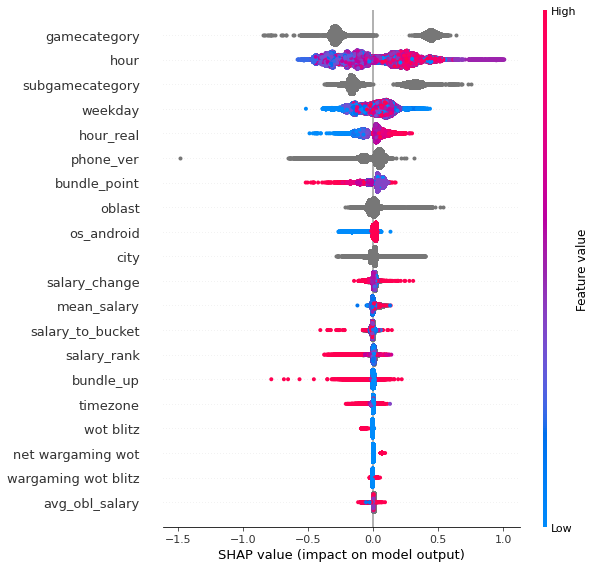

In [ ]:
cb, shap_values, imps = learn_model_for_target(
    pred_df_train.drop(['day'], axis=1), 
    pred_df_val.drop(['day'], axis=1), targ=1)

Learning rate set to 0.040161
0:	learn: 0.5303425	test: 0.5378712	best: 0.5378712 (0)	total: 56.2ms	remaining: 56.1s
150:	learn: 0.7230633	test: 0.7245063	best: 0.7245063 (150)	total: 8.5s	remaining: 47.8s
300:	learn: 0.7301240	test: 0.7283548	best: 0.7283548 (300)	total: 17s	remaining: 39.4s
450:	learn: 0.7353430	test: 0.7301719	best: 0.7302123 (440)	total: 26s	remaining: 31.6s
600:	learn: 0.7391596	test: 0.7315390	best: 0.7315390 (600)	total: 34.9s	remaining: 23.1s
750:	learn: 0.7423122	test: 0.7319669	best: 0.7319669 (750)	total: 43.8s	remaining: 14.5s
bestTest = 0.7319822311
bestIteration = 757
Shrink model to first 758 iterations.


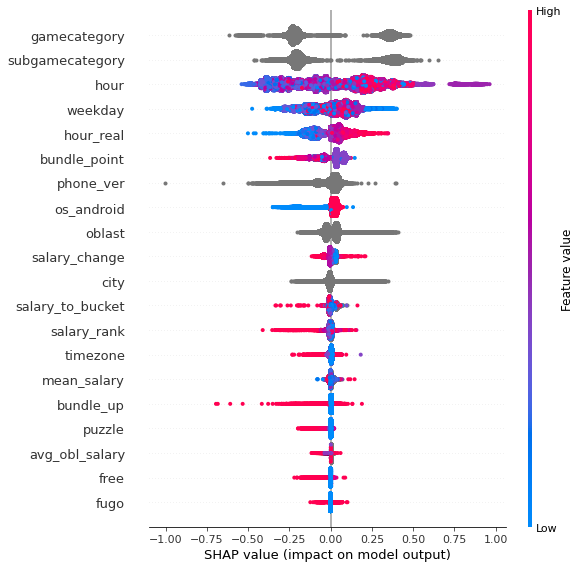

In [ ]:
cb_1, shap_values_1, imps_1 = learn_model_for_target(pred_df_train, pred_df_val, targ=1,
                                                     cols = list(imps[imps.imp>0.1]['cols']))

In [ ]:
cb_1.save_model(f'drive/MyDrive/rsv21_3/model_1_{postfix}')
joblib.dump(list(imps[imps.imp>0.1]['cols']), f'drive/MyDrive/rsv21_3/cols_1_{postfix}')

['drive/MyDrive/rsv21_3/cols_1_v4']

### Model for segment 2

Learning rate set to 0.040161
0:	learn: 0.7347994	test: 0.7326773	best: 0.7326773 (0)	total: 56.9ms	remaining: 56.9s
150:	learn: 0.8596758	test: 0.8567111	best: 0.8567111 (150)	total: 8.92s	remaining: 50.1s
300:	learn: 0.8636680	test: 0.8609712	best: 0.8609712 (300)	total: 17.6s	remaining: 41s
450:	learn: 0.8656606	test: 0.8627877	best: 0.8627906 (444)	total: 26.6s	remaining: 32.3s
600:	learn: 0.8671944	test: 0.8639975	best: 0.8639975 (600)	total: 35.4s	remaining: 23.5s
750:	learn: 0.8685050	test: 0.8648677	best: 0.8648761 (744)	total: 44.3s	remaining: 14.7s
900:	learn: 0.8694575	test: 0.8652743	best: 0.8652743 (900)	total: 53.3s	remaining: 5.86s
bestTest = 0.8652743101
bestIteration = 900
Shrink model to first 901 iterations.


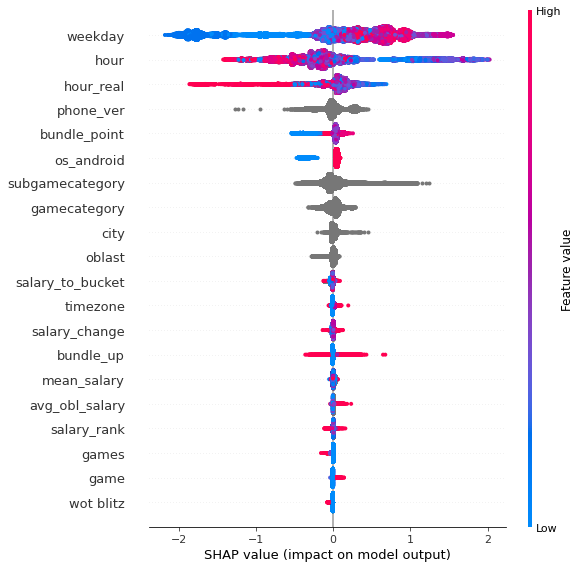

CPU times: user 2min 1s, sys: 14.5 s, total: 2min 16s
Wall time: 1min 25s


In [ ]:
%%time
cb2, shap_values2, imps2 = learn_model_for_target(
        pred_df_train.drop(['day'], axis=1), 
        pred_df_val.drop(['day'], axis=1), targ=2)

0:	learn: 0.6508864	test: 0.6513923	best: 0.6513923 (0)	total: 38.3ms	remaining: 38.2s
150:	learn: 0.8642991	test: 0.8618508	best: 0.8618635 (149)	total: 8.75s	remaining: 49.2s
300:	learn: 0.8676278	test: 0.8640494	best: 0.8640760 (294)	total: 17.6s	remaining: 40.8s
450:	learn: 0.8699903	test: 0.8648301	best: 0.8648842 (446)	total: 26.4s	remaining: 32.2s
600:	learn: 0.8722364	test: 0.8655553	best: 0.8655553 (600)	total: 35.3s	remaining: 23.5s
750:	learn: 0.8741709	test: 0.8659095	best: 0.8659212 (741)	total: 44.4s	remaining: 14.7s
900:	learn: 0.8759512	test: 0.8664153	best: 0.8664153 (900)	total: 53.4s	remaining: 5.87s
999:	learn: 0.8771391	test: 0.8667050	best: 0.8667171 (957)	total: 59.3s	remaining: 0us
bestTest = 0.8667171299
bestIteration = 957
Shrink model to first 958 iterations.


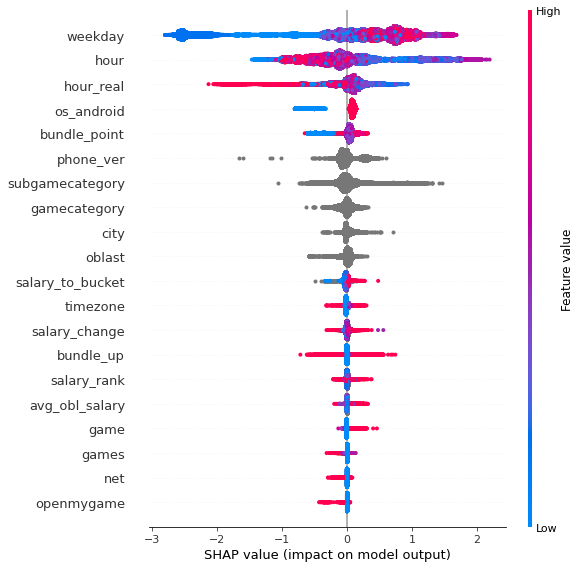

In [ ]:
cb_2, shap_values_2, imps_2 = learn_model_for_target(pred_df_train, pred_df_val, targ=2,
                                                     cols = list(imps2[imps2.imp>0.1]['cols']))

In [ ]:
cb_2.save_model(f'drive/MyDrive/rsv21_3/model_2_{postfix}')
joblib.dump(list(imps2[imps2.imp>0.1]['cols']), f'drive/MyDrive/rsv21_3/cols_2_{postfix}')

['drive/MyDrive/rsv21_3/cols_2_v4']

### Model for segment 3

Learning rate set to 0.040161
0:	learn: 0.6934246	test: 0.6918323	best: 0.6918323 (0)	total: 65.4ms	remaining: 1m 5s
150:	learn: 0.7211197	test: 0.7190492	best: 0.7190492 (150)	total: 8.86s	remaining: 49.8s
300:	learn: 0.7240486	test: 0.7213306	best: 0.7213341 (299)	total: 17.3s	remaining: 40.3s
450:	learn: 0.7262596	test: 0.7229802	best: 0.7229802 (450)	total: 26.1s	remaining: 31.7s
600:	learn: 0.7274051	test: 0.7236491	best: 0.7236491 (600)	total: 34.9s	remaining: 23.2s
750:	learn: 0.7283239	test: 0.7240553	best: 0.7240553 (750)	total: 43.6s	remaining: 14.5s
900:	learn: 0.7291139	test: 0.7243945	best: 0.7243975 (899)	total: 52.6s	remaining: 5.78s
999:	learn: 0.7295724	test: 0.7245790	best: 0.7245790 (999)	total: 58.3s	remaining: 0us
bestTest = 0.7245790064
bestIteration = 999


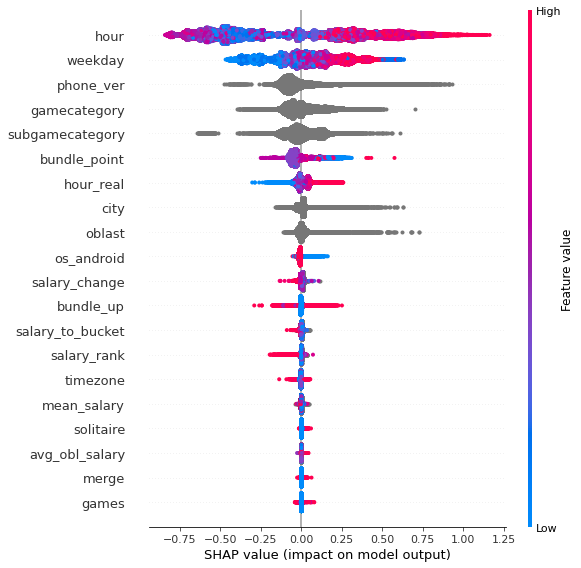

CPU times: user 2min 9s, sys: 15.2 s, total: 2min 24s
Wall time: 1min 29s


In [ ]:
%%time
cb3, shap_values3, imps3 = learn_model_for_target(
     pred_df_train.drop(['day'], axis=1), 
        pred_df_val.drop(['day'], axis=1), targ=3)

0:	learn: 0.6941825	test: 0.6930225	best: 0.6930225 (0)	total: 63ms	remaining: 1m 2s
150:	learn: 0.7236757	test: 0.7212732	best: 0.7212753 (148)	total: 8.59s	remaining: 48.3s
300:	learn: 0.7267537	test: 0.7234627	best: 0.7234627 (300)	total: 17.1s	remaining: 39.7s
450:	learn: 0.7285678	test: 0.7244706	best: 0.7244706 (450)	total: 25.6s	remaining: 31.1s
600:	learn: 0.7298438	test: 0.7249687	best: 0.7249695 (595)	total: 34.2s	remaining: 22.7s
750:	learn: 0.7309405	test: 0.7253078	best: 0.7253135 (723)	total: 42.7s	remaining: 14.1s
900:	learn: 0.7319332	test: 0.7256169	best: 0.7256169 (900)	total: 51.4s	remaining: 5.65s
999:	learn: 0.7324607	test: 0.7256954	best: 0.7256977 (995)	total: 57.1s	remaining: 0us
bestTest = 0.7256976962
bestIteration = 995
Shrink model to first 996 iterations.


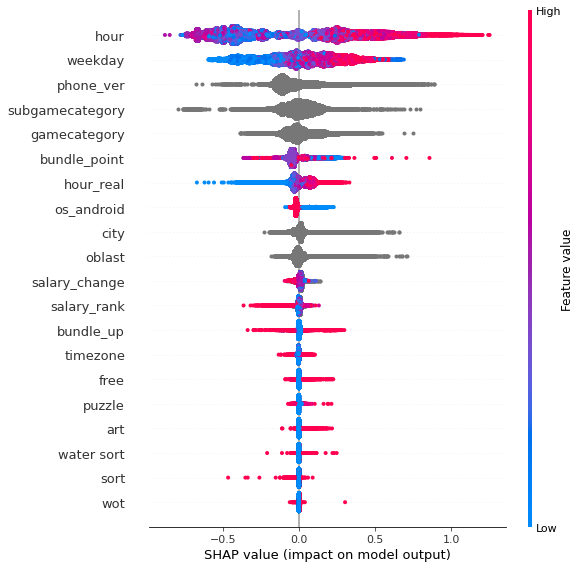

In [ ]:
cb_3, shap_values_3, imps_3 = learn_model_for_target(pred_df_train, pred_df_val, targ=3,
                                                     cols = list(imps3[imps3.imp>0.1]['cols']),
                                                     lr=0.07)

In [ ]:
cb_3.save_model(f'drive/MyDrive/rsv21_3/model_3_{postfix}')
joblib.dump(list(imps3[imps3.imp>0.1]['cols']), f'drive/MyDrive/rsv21_3/cols_3_{postfix}')

['drive/MyDrive/rsv21_3/cols_3_v4']

### Model for segment 4

Learning rate set to 0.040161
0:	learn: 0.7209977	test: 0.7238435	best: 0.7238435 (0)	total: 60.9ms	remaining: 1m
150:	learn: 0.7589528	test: 0.7620255	best: 0.7620255 (150)	total: 9s	remaining: 50.6s
300:	learn: 0.7623050	test: 0.7647548	best: 0.7647548 (300)	total: 17.6s	remaining: 41s
450:	learn: 0.7641419	test: 0.7660613	best: 0.7660613 (450)	total: 26.6s	remaining: 32.4s
600:	learn: 0.7652123	test: 0.7666310	best: 0.7666326 (599)	total: 35.6s	remaining: 23.6s
750:	learn: 0.7660064	test: 0.7669342	best: 0.7669352 (746)	total: 44.6s	remaining: 14.8s
900:	learn: 0.7666811	test: 0.7671333	best: 0.7671333 (900)	total: 53.7s	remaining: 5.9s
999:	learn: 0.7670980	test: 0.7672399	best: 0.7672399 (999)	total: 59.7s	remaining: 0us
bestTest = 0.7672398984
bestIteration = 999


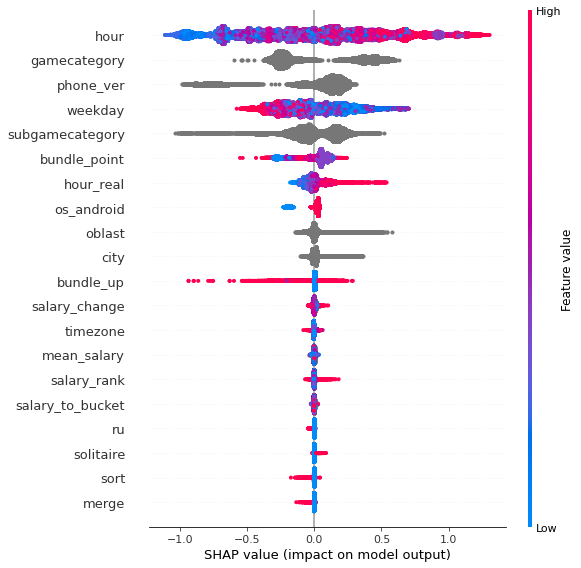

CPU times: user 2min 11s, sys: 15.1 s, total: 2min 26s
Wall time: 1min 31s


In [ ]:
%%time
cb4, shap_values4, imps4 = learn_model_for_target(
     pred_df_train.drop(['day'], axis=1), 
        pred_df_val.drop(['day'], axis=1), targ=4)

0:	learn: 0.7207364	test: 0.7226797	best: 0.7226797 (0)	total: 66.1ms	remaining: 1m 5s
150:	learn: 0.7611350	test: 0.7636601	best: 0.7636601 (150)	total: 8.82s	remaining: 49.6s
300:	learn: 0.7643882	test: 0.7660672	best: 0.7660672 (300)	total: 17.5s	remaining: 40.6s
450:	learn: 0.7660918	test: 0.7669778	best: 0.7669778 (450)	total: 26.4s	remaining: 32.1s
600:	learn: 0.7672136	test: 0.7673376	best: 0.7673409 (598)	total: 35.1s	remaining: 23.3s
750:	learn: 0.7681172	test: 0.7674869	best: 0.7674869 (750)	total: 44s	remaining: 14.6s
900:	learn: 0.7690354	test: 0.7676685	best: 0.7676747 (883)	total: 53s	remaining: 5.82s
999:	learn: 0.7695692	test: 0.7676781	best: 0.7676933 (956)	total: 58.8s	remaining: 0us
bestTest = 0.767693311
bestIteration = 956
Shrink model to first 957 iterations.


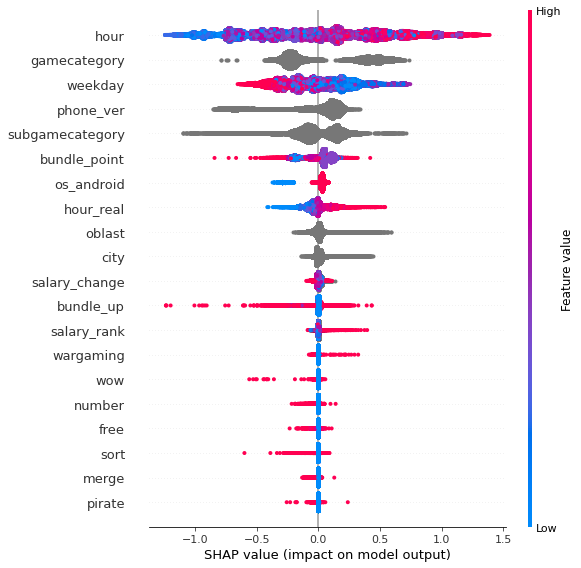

In [ ]:
cb_4, shap_values_4, imps_4 = learn_model_for_target(pred_df_train, pred_df_val, targ=4,
                                                     cols = list(imps4[imps4.imp>0.1]['cols']),
                                                     lr = 0.07)

In [ ]:
cb_4.save_model(f'drive/MyDrive/rsv21_3/model_4_{postfix}')
joblib.dump(list(imps4[imps4.imp>0.1]['cols']), f'drive/MyDrive/rsv21_3/cols_4_{postfix}')

['drive/MyDrive/rsv21_3/cols_4_v4']

### Model for segment 5

Learning rate set to 0.040161
0:	learn: 0.7662469	test: 0.7649938	best: 0.7649938 (0)	total: 66.8ms	remaining: 1m 6s
150:	learn: 0.7977121	test: 0.7969685	best: 0.7969685 (150)	total: 8.76s	remaining: 49.2s
300:	learn: 0.8018075	test: 0.8008604	best: 0.8008604 (300)	total: 17.4s	remaining: 40.3s
450:	learn: 0.8035789	test: 0.8023641	best: 0.8023641 (450)	total: 26.2s	remaining: 31.9s
600:	learn: 0.8045838	test: 0.8030748	best: 0.8030751 (599)	total: 35.1s	remaining: 23.3s
750:	learn: 0.8054105	test: 0.8036156	best: 0.8036156 (750)	total: 43.9s	remaining: 14.6s
900:	learn: 0.8060030	test: 0.8038888	best: 0.8038888 (900)	total: 52.7s	remaining: 5.79s
999:	learn: 0.8063527	test: 0.8040402	best: 0.8040442 (996)	total: 58.5s	remaining: 0us
bestTest = 0.8040441871
bestIteration = 996
Shrink model to first 997 iterations.


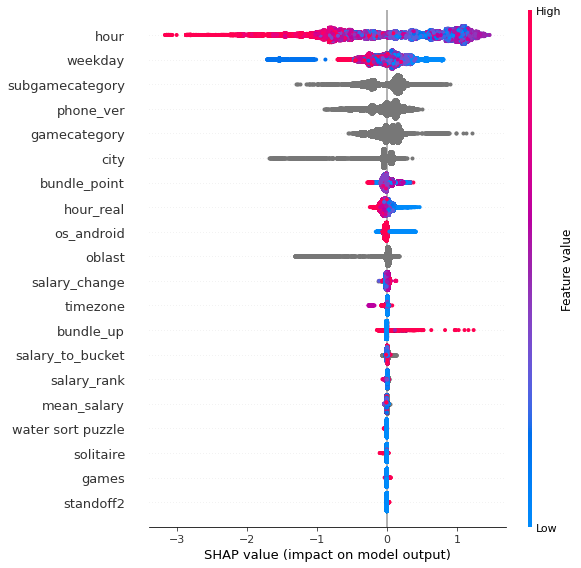

CPU times: user 2min 7s, sys: 15.2 s, total: 2min 22s
Wall time: 1min 28s


In [ ]:
%%time
cb5, shap_values5, imps5 = learn_model_for_target(
     pred_df_train.drop(['day'], axis=1), 
        pred_df_val.drop(['day'], axis=1), targ=5)

0:	learn: 0.7696044	test: 0.7687426	best: 0.7687426 (0)	total: 63.5ms	remaining: 1m 3s
150:	learn: 0.8011997	test: 0.8003840	best: 0.8003840 (150)	total: 8.74s	remaining: 49.1s
300:	learn: 0.8042422	test: 0.8029468	best: 0.8029476 (299)	total: 17.3s	remaining: 40.3s
450:	learn: 0.8055821	test: 0.8037619	best: 0.8037626 (449)	total: 25.9s	remaining: 31.5s
600:	learn: 0.8065419	test: 0.8042387	best: 0.8042392 (598)	total: 34.6s	remaining: 22.9s
750:	learn: 0.8074116	test: 0.8046017	best: 0.8046017 (750)	total: 43.3s	remaining: 14.3s
900:	learn: 0.8080475	test: 0.8047824	best: 0.8047828 (895)	total: 51.8s	remaining: 5.69s
999:	learn: 0.8085168	test: 0.8049605	best: 0.8049605 (999)	total: 57.5s	remaining: 0us
bestTest = 0.8049604595
bestIteration = 999


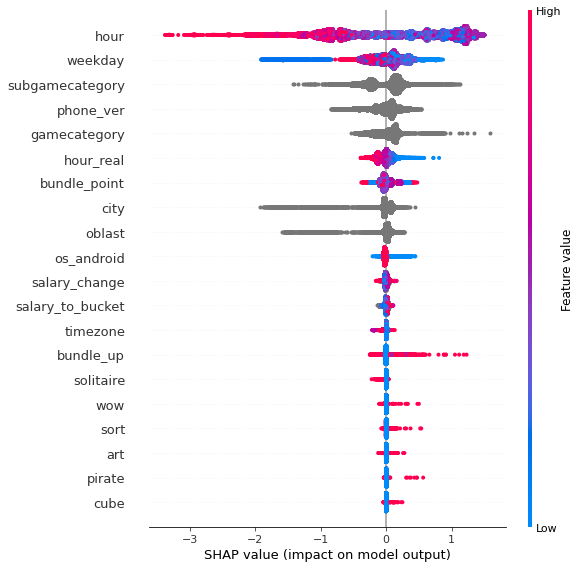

In [ ]:
cb_5, shap_values_5, imps_5 = learn_model_for_target(pred_df_train, pred_df_val, targ=5,
                                                     cols = list(imps5[imps5.imp>0.1]['cols']),
                                                     lr=0.07)

In [ ]:
cb_5.save_model(f'drive/MyDrive/rsv21_3/model_5_{postfix}')
joblib.dump(list(imps5[imps5.imp>0.1]['cols']), f'drive/MyDrive/rsv21_3/cols_5_{postfix}')

['drive/MyDrive/rsv21_3/cols_5_v4']

### Scoring

In [ ]:
%%time
test_df = pd.read_csv('test.csv')
print('Read data')
test_df = preprocess(test_df)
print('Preprocess')
pred_df_test = tfidf_feats(test_df, is_train=False, postfix = postfix)
print('tfidf')
cb = CatBoostClassifier()
for i in tqdm_notebook(range(5)):
  cb.load_model(f'drive/MyDrive/rsv21_3/model_{i+1}_{postfix}')
  cols = cb.feature_names_
  pred_df_test[f'scor_{i+1}'] = cb.predict_proba(pred_df_test[cols])[:,1]
pred_df_test['id'] = pred_df_test.index
pred_df_test = pred_df_test[['id', 'scor_1', 'scor_2', 'scor_3', 'scor_4', 'scor_5']]
pred_df_test.to_csv(f'drive/MyDrive/rsv21_3/scor_{postfix}.csv', index=False)

### ROC-AUC

  0%|          | 0/5 [00:00<?, ?it/s]

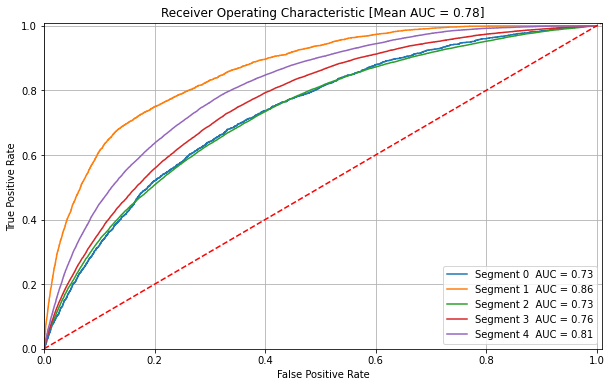

In [ ]:
from sklearn.metrics import roc_curve, auc
fig = plt.figure(figsize=(10,6))
all_rocs = []
cb = CatBoostClassifier()
for i in tqdm_notebook(range(5)):
  cb.load_model(f'drive/MyDrive/rsv21_3/model_{i+1}_{postfix}')
  cols = cb.feature_names_
  y_probas = cb.predict_proba(pred_df_val[cols])[:,1]
  y_true = (pred_df_val['Segment'] == i+1).astype(int)

  fpr, tpr, threshold = roc_curve(y_true, y_probas)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label = f'Segment {i}  AUC = {round(roc_auc,2)}')
  plt.legend(loc = 'lower right')
  all_rocs.append(roc_auc)
plt.title(f'Receiver Operating Characteristic [Mean AUC = {round(np.mean(all_rocs),2)}]')
plt.plot([0, 1.01], [0, 1.01],'r--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()  

### Wordcloud

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Функция для визуализации облака слов
def plot_cloud(wordcloud):
    # Устанавливаем размер картинки
    plt.figure(figsize=(4, 3))
    # Показать изображение
    plt.imshow(wordcloud) 
    # Без подписей на осях
    plt.axis("off")

1
2
3
4
5


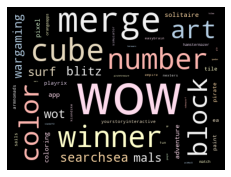

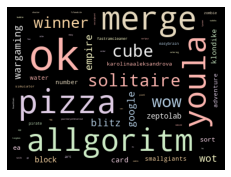

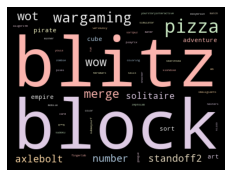

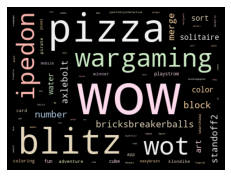

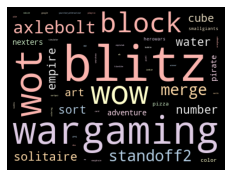

In [ ]:
from wordcloud import WordCloud
# from stop_words import get_stop_words

# Записываем в переменную стоп-слова русского языка
# STOPWORDS_RU = get_stop_words('english')
for i in range(5):
  print(i+1)
  text = " ".join(prep_df[prep_df.Segment==i+1].sample(n=10000)['bundle_new'].values)
  # Генерируем облако слов
  wordcloud = WordCloud(width = 400, 
                        height = 300, 
                        random_state=1, 
                        background_color='black', 
                        margin=20, 
                        colormap='Pastel1', 
                        collocations=False, 
                        # stopwords = STOPWORDS_RU
                        ).generate(text)
  plot_cloud(wordcloud)